In [249]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [250]:
directory = os.path.abspath("") + '/dataset/cardano/'
data = pd.read_csv(directory + 'data.csv', on_bad_lines = 'skip')
size = pd.read_csv(directory + 'size.csv', on_bad_lines = 'skip')

In [251]:
# Perform a merge
ECDSA = pd.merge(data, size, how='inner', on='BlockNo')

ECDSA = ECDSA.sort_values(by='BlockNo')

ECDSA.describe()

,BlockNo,Timestamp,TxCount,TotalFees,BlockSize
count,1.568457e+06,1.568457e+06,1.568457e+06,1.568457e+06,1.568457e+06
mean,9.098573e+06,1.690755e+12,1.575307e+01,5.485629e+06,3.865590e+04
std,4.620535e+05,9.496789e+09,1.357235e+01,4.344070e+06,3.102190e+04
min,8.298300e+06,1.674282e+12,0.000000e+00,0.000000e+00,4.000000e+00
25%,8.698274e+06,1.682535e+12,5.000000e+00,1.702637e+06,1.006200e+04
50%,9.099558e+06,1.690782e+12,1.200000e+01,4.602655e+06,3.168300e+04
75%,9.498903e+06,1.698983e+12,2.300000e+01,8.745125e+06,6.838800e+04
max,9.898300e+06,1.707203e+12,3.850000e+02,1.886130e+08,8.905200e+04


The formula for calculating minimal fees for a transaction (tx) is:

a * size(tx) + b, where:

a/b are protocol parameters, size(tx) is the transaction size in bytes

b is independent of the size of the transaction and can be considered as a constant.

In [252]:
# Drop blocks with no transactions
ECDSA = ECDSA[ECDSA['TxCount'] != 0]

ECDSA['AvgTxSize'] = ECDSA['BlockSize'] / ECDSA['TxCount']

ECDSA['Timestamp'] = ECDSA['Timestamp'] / 1000

ECDSA['Date'] = ECDSA['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))

ECDSA['AvgTxFee'] = ECDSA['TotalFees'] / ECDSA['TxCount']

ECDSA['A'] = ECDSA['AvgTxFee'] / ECDSA['AvgTxSize']

# Max No of Transactions possible in a 65,536 bytes block limit
ECDSA['NoMaxTxPossible'] = 65536 / ECDSA['AvgTxSize']

ECDSA['BlockTime'] = ECDSA['Timestamp'].diff()

# Drop blocks with no 
ECDSA = ECDSA[ECDSA['BlockTime'] != 0]

ECDSA.describe()

,BlockNo,Timestamp,TxCount,TotalFees,BlockSize,AvgTxSize,Date,AvgTxFee,A,NoMaxTxPossible,BlockTime
count,1.493723e+06,1.493723e+06,1.493723e+06,1.493723e+06,1.493723e+06,1.493723e+06,1493723,1.493723e+06,1.493723e+06,1.493723e+06,1.493722e+06
mean,9.097700e+06,1.690737e+09,1.654030e+01,5.759759e+06,4.058734e+04,2.626850e+03,2023-07-30 17:02:59.235758848,3.623443e+05,1.769825e+02,3.838016e+01,2.203940e+01
min,8.298300e+06,1.674282e+09,1.000000e+00,1.637850e+05,1.920000e+02,1.920000e+02,2023-01-21 06:27:53,1.637850e+05,5.348818e+01,4.000000e+00,1.000000e+00
25%,8.698086e+06,1.682531e+09,6.000000e+00,2.048348e+06,1.275900e+04,1.499000e+03,2023-04-26 17:46:47,2.792005e+05,1.203911e+02,1.998760e+01,7.000000e+00
50%,9.094110e+06,1.690673e+09,1.300000e+01,4.947217e+06,3.429100e+04,2.233188e+03,2023-07-29 23:24:00,3.363832e+05,1.476221e+02,2.934639e+01,1.600000e+01
75%,9.501092e+06,1.699029e+09,2.400000e+01,8.943634e+06,7.100950e+04,3.278833e+03,2023-11-03 16:31:39,4.135572e+05,1.914892e+02,4.371981e+01,3.000000e+01
max,9.898300e+06,1.707203e+09,3.850000e+02,1.886130e+08,8.905200e+04,1.638400e+04,2024-02-06 07:06:43,3.968407e+07,3.082657e+04,3.413333e+02,4.022400e+04
std,4.630451e+05,9.517135e+06,1.343107e+01,4.270260e+06,3.052961e+04,1.737114e+03,NaN,1.406602e+05,1.366361e+02,3.336891e+01,3.954476e+01


Text(0.5, 1.0, 'Correlation between features')

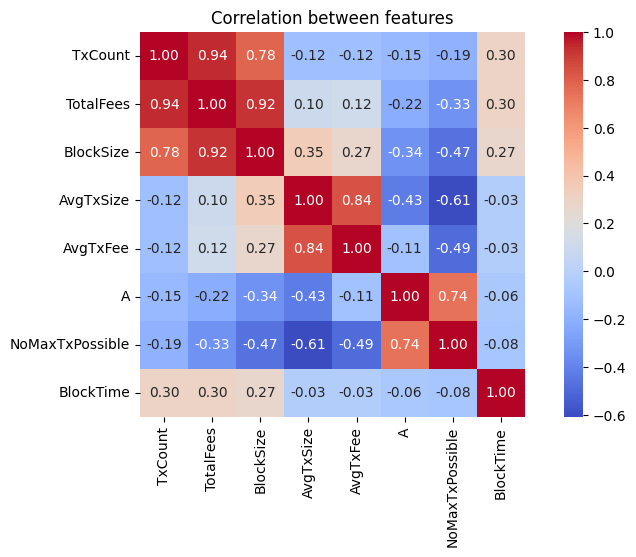

In [253]:
ECDSA_CORR = ECDSA.copy().drop(labels=['Timestamp', 'Date', 'BlockNo'], axis=1).corr()
plt.figure(figsize=(10,5))
sns.heatmap(ECDSA_CORR, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.title('Correlation between features')

In [254]:
def getPQAvgTransactionSize(ECDSATxSize, PQ_SIG_SIZE: int):
    
    # ECDSA (bytes)
    ECDSA_SIG_SIZE = 64

    PQ_TxSize = ECDSATxSize - ECDSA_SIG_SIZE + PQ_SIG_SIZE

    return PQ_TxSize

In [255]:
FALCON_512_SIG_SIZE = 666 # (bytes)

FALCON = pd.DataFrame()

FALCON['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], FALCON_512_SIG_SIZE)

FALCON['Date'] = ECDSA['Date']

# We assume the same A protocol parameter
FALCON['AvgTxFee'] = ECDSA['A'] * FALCON['AvgTxSize']

# Max No of Transactions possible in a 65,536 bytes block limit
FALCON['NoMaxTxPossible'] = 65536 / FALCON['AvgTxSize']

FALCON.describe()

,AvgTxSize,Date,AvgTxFee,NoMaxTxPossible
count,1.493723e+06,1493723,1.493723e+06,1.493723e+06
mean,3.228850e+03,2023-07-30 17:02:59.235758848,4.688878e+05,2.566454e+01
min,7.940000e+02,2023-01-21 06:27:53,3.099363e+05,3.858236e+00
25%,2.101000e+03,2023-04-26 17:46:47,3.907082e+05,1.688709e+01
50%,2.835188e+03,2023-07-29 23:24:00,4.369482e+05,2.311523e+01
75%,3.880833e+03,2023-11-03 16:31:39,5.061646e+05,3.119277e+01
max,1.698600e+04,2024-02-06 07:06:43,5.824166e+07,8.253904e+01
std,1.737114e+03,NaN,1.548146e+05,1.272366e+01


In [256]:
DILITHIUM_SIG_SIZE = 2420 # (bytes)

DILITHIUM = pd.DataFrame()

DILITHIUM['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], DILITHIUM_SIG_SIZE)

DILITHIUM['Date'] = ECDSA['Date']

# We assume the same A protocol parameter
DILITHIUM['AvgTxFee'] = ECDSA['A'] * DILITHIUM['AvgTxSize']

# Max No of Transactions possible in a 65,536 bytes block limit
DILITHIUM['NoMaxTxPossible'] = 65536 / DILITHIUM['AvgTxSize']

DILITHIUM.describe()

,AvgTxSize,Date,AvgTxFee,NoMaxTxPossible
count,1.493723e+06,1493723,1.493723e+06,1.493723e+06
mean,4.982850e+03,2023-07-30 17:02:59.235758848,7.793151e+05,1.442413e+01
min,2.548000e+03,2023-01-21 06:27:53,5.125739e+05,3.497118e+00
25%,3.855000e+03,2023-04-26 17:46:47,6.582160e+05,1.163051e+01
50%,4.589188e+03,2023-07-29 23:24:00,7.157120e+05,1.428052e+01
75%,5.634833e+03,2023-11-03 16:31:39,8.086176e+05,1.700026e+01
max,1.874000e+04,2024-02-06 07:06:43,1.123115e+08,2.572057e+01
std,1.737114e+03,NaN,3.366051e+05,4.051000e+00


In [257]:
SPHINCS_SIG_SIZE = 17088 # (bytes)

SPHINCS = pd.DataFrame()

SPHINCS['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], SPHINCS_SIG_SIZE)

SPHINCS['Date'] = ECDSA['Date']

# We assume the same A protocol parameter
SPHINCS['AvgTxFee'] = ECDSA['A'] * SPHINCS['AvgTxSize']

# Max No of Transactions possible in a 65,536 bytes block limit
SPHINCS['NoMaxTxPossible'] = 65536 / SPHINCS['AvgTxSize']

SPHINCS.describe()

,AvgTxSize,Date,AvgTxFee,NoMaxTxPossible
count,1.493723e+06,1493723,1.493723e+06,1.493723e+06
mean,1.965085e+04,2023-07-30 17:02:59.235758848,3.375294e+06,3.357864e+00
min,1.721600e+04,2023-01-21 06:27:53,1.586527e+06,1.961686e+00
25%,1.852300e+04,2023-04-26 17:46:47,2.447461e+06,3.227924e+00
50%,1.925719e+04,2023-07-29 23:24:00,2.858441e+06,3.403197e+00
75%,2.030283e+04,2023-11-03 16:31:39,3.566700e+06,3.538088e+00
max,3.340800e+04,2024-02-06 07:06:43,5.644756e+08,3.806691e+00
std,1.737114e+03,NaN,2.314612e+06,2.615062e-01


#### AVERAGE TRANSACTIONS PER SECOND

> Average TPS = (Average Block Size / Average Transaction Size) / Average Block Time

In [258]:
ECDSA['AverageTPS'] = (ECDSA['BlockSize'] / ECDSA['AvgTxSize']) / ECDSA['BlockTime']
FALCON['AverageTPS'] = (ECDSA['BlockSize'] / FALCON['AvgTxSize']) / ECDSA['BlockTime']
DILITHIUM['AverageTPS'] = (ECDSA['BlockSize'] / DILITHIUM['AvgTxSize']) / ECDSA['BlockTime']
SPHINCS['AverageTPS'] = (ECDSA['BlockSize'] / SPHINCS['AvgTxSize']) / ECDSA['BlockTime']

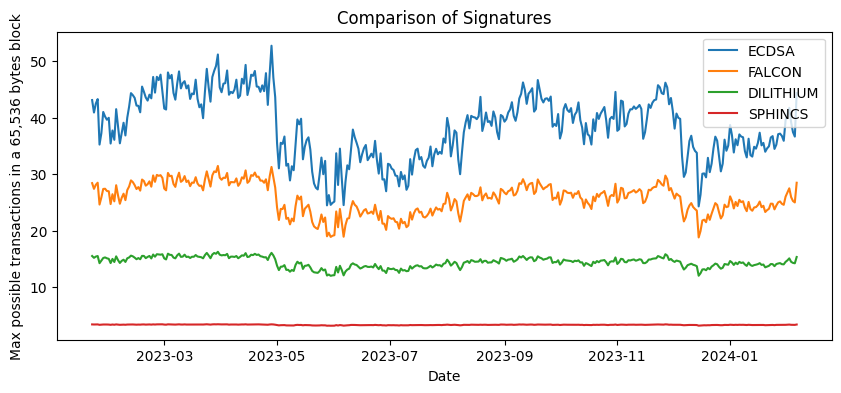

In [259]:
ECDSA_resampled = ECDSA.resample('1d', on='Date').mean()
FALCON_resampled = FALCON.resample('1d', on='Date').mean()
DILITHIUM_resampled = DILITHIUM.resample('1d', on='Date').mean()
SPHINCS_resampled = SPHINCS.resample('1d', on='Date').mean()

plt.figure(figsize=(10, 4))
plt.plot(ECDSA_resampled['NoMaxTxPossible'], label='ECDSA')
plt.plot(FALCON_resampled['NoMaxTxPossible'], label='FALCON')
plt.plot(DILITHIUM_resampled['NoMaxTxPossible'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['NoMaxTxPossible'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Max possible transactions in a 65,536 bytes block')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

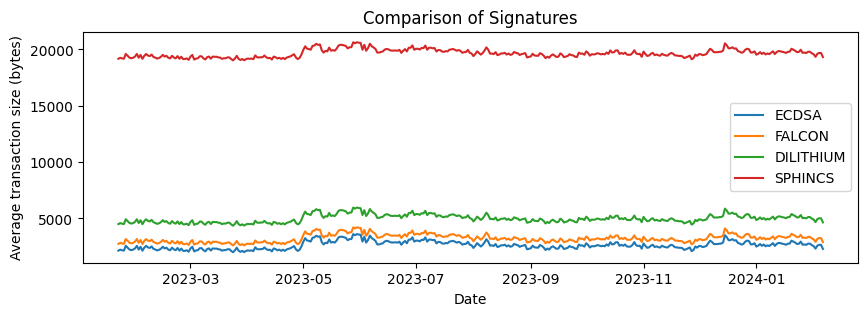

In [260]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AvgTxSize'], label='ECDSA')
plt.plot(FALCON_resampled['AvgTxSize'], label='FALCON')
plt.plot(DILITHIUM_resampled['AvgTxSize'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AvgTxSize'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transaction size (bytes)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

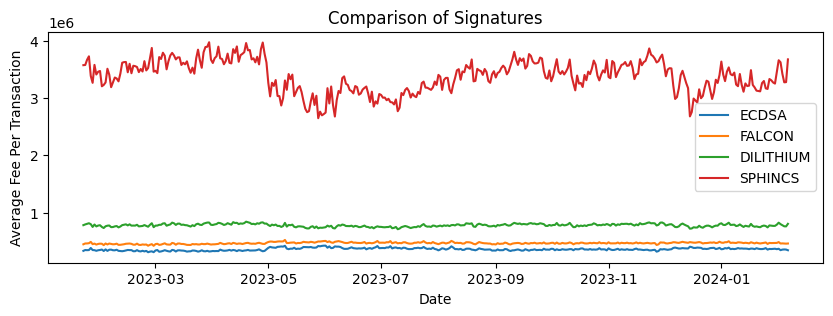

In [261]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AvgTxFee'], label='ECDSA')
plt.plot(FALCON_resampled['AvgTxFee'], label='FALCON')
plt.plot(DILITHIUM_resampled['AvgTxFee'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AvgTxFee'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average Fee Per Transaction')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

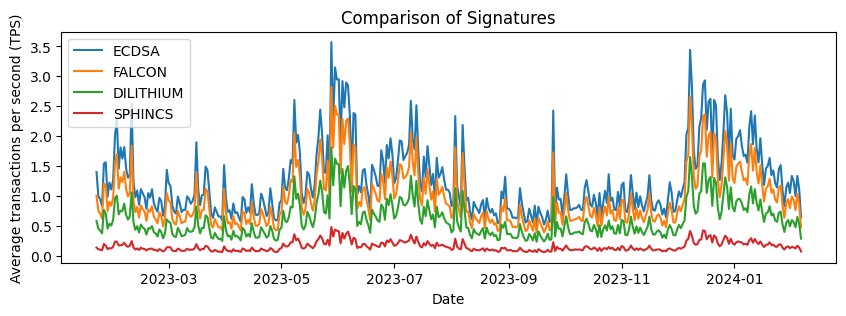

In [262]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AverageTPS'], label='ECDSA')
plt.plot(FALCON_resampled['AverageTPS'], label='FALCON')
plt.plot(DILITHIUM_resampled['AverageTPS'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AverageTPS'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transactions per second (TPS)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()